# Invest at once or over time even if you need to borrow?

Does it make sense to leverage an ETF investment on your own by getting a consumer credit?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (7,3)

## Simulation Preparation

First, we need a way to simulate ETF performance.
The idea is a simple [random walk](https://en.wikipedia.org/wiki/Random_walk_hypothesis) model, where each month is log-normal difference with a slight upward trend.

In [2]:
MONTHLY_ROI = 0.004
SIGMA = 0.045
print(f"Yearly interest: {((1 + MONTHLY_ROI)**12 - 1)*100:.1f}%")

Yearly interest: 4.9%


Let's plot a few to see if they look reasonable.

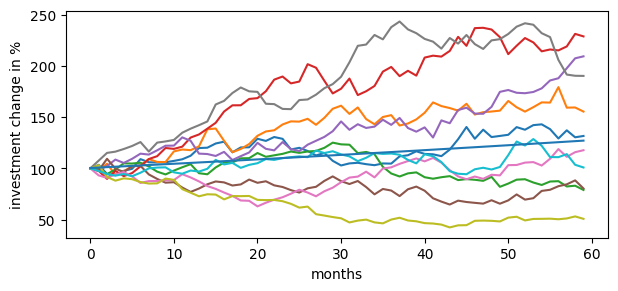

In [3]:
YEARS=5
def many_market_monthly_diffs(years=5, count=10, seed=9194487):
    rng = np.random.default_rng(seed=seed)
    diffs = rng.lognormal(MONTHLY_ROI, SIGMA, (years*12, count))
    diffs[0] = np.ones(count)
    return np.cumprod(diffs, axis=0)
COUNT = 10
d = many_market_monthly_diffs(years=YEARS, count=COUNT)
plt.plot(100 * d)
# the non-randomized case as well:
plt.plot(100 * np.cumprod(np.full(YEARS*12, (MONTHLY_ROI + 1))))
plt.xlabel('months')
plt.ylabel('investment change in %')
plt.show()

Let's compare it to historic FTSE All World data:

1. Use the difference between open and close for each month.
2. Normalize to the open price
3. Square and average to compute the variance
4. Square root for standard deviation

Use something slightly higher to be pessimistic about our risk.

In [4]:
df = pd.read_csv("VWRD.L.csv")
print(df)

           Date        Open        High         Low       Close   Adj Close  \
0    2012-06-01   49.680000   51.439999   49.680000   51.290001   51.290001   
1    2012-07-01   51.490002   52.330002   52.330002   52.384998   52.384998   
2    2012-08-01   52.230000   54.000000   53.410000   53.505001   53.505001   
3    2012-09-01   53.575001   56.660000   54.730000   54.634998   54.634998   
4    2012-10-01   55.465000   56.360001   54.570000   54.349998   54.349998   
..          ...         ...         ...         ...         ...         ...   
110  2021-08-01  120.480003  123.089996  117.379997  122.029999  122.029999   
111  2021-09-01  122.690002  123.730003  117.199997  117.300003  117.300003   
112  2021-10-01  115.589996  123.059998  114.900002  122.339996  122.339996   
113  2021-11-01  122.779999  124.970001  119.500000  119.620003  119.620003   
114  2021-12-01  120.730003  124.480003  117.989998  124.364998  124.364998   

      Volume  
0       4610  
1       5000  
2     

In [5]:
print(f"monthly data from {df['Date'][0]} to {df['Date'][114]}")
start_val = df['Open'][0]
end_val = df['Close'][114]
ftse_growth = (end_val - start_val) / start_val
print(f"From a start of {start_val} to an end of {end_val}, it grew by {ftse_growth * 100:.0f}%")
ftse_growth_monthly = (1 + ftse_growth) ** (1.0/114) - 1
ftse_growth_yearly = (1 + ftse_growth) ** (1.0/114*12) - 1
print(f"That corresponds to a constant monthly growth of {ftse_growth_monthly:.4f} ({ftse_growth_yearly:.4f} yearly).")
print(f"For further calculations we use a more pessimistic {MONTHLY_ROI} though.")

monthly data from 2012-06-01 to 2021-12-01
From a start of 49.68 to an end of 124.364998, it grew by 150%
That corresponds to a constant monthly growth of 0.0081 (0.1014 yearly).
For further calculations we use a more pessimistic 0.004 though.


In [6]:
normalized_diffs = (df['Close'] - df['Open']) / df['Open']
# close-open ignores the gaps compared to an open-to-open comparison!
variance = np.sum(normalized_diffs ** 2) / len(df['Close'])
stddev = variance ** 0.5
print(f"FTSE All World stddev is {stddev:.5f}.")
print(f"For further calculations we use a more pessimistic {SIGMA:.5f} though.")
assert(stddev < SIGMA)

FTSE All World stddev is 0.03832.
For further calculations we use a more pessimistic 0.04500 though.


## Single Investment

Now what happens if we invest once and then wait for a few years?
The actual development will look like the plots above.
The distribution of many different outcomes is the interesting thing.

For comparison, we look at some percentiles.

In [7]:
def percentiles(data):
    data.sort()
    l = len(data)
    for p in (0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9):
        yield int(100*p), data[int(l * p)]
        #print(f"Percentile {int(100*p)}: {value}")
for p,v in percentiles([3,5,7,2,1]):
    print(f"Percentile {p}: {v}")

Percentile 10: 1
Percentile 20: 2
Percentile 30: 2
Percentile 50: 3
Percentile 70: 5
Percentile 80: 7
Percentile 90: 7


Percentile 10: 81.1
Percentile 20: 94.4
Percentile 30: 104.9
Percentile 50: 125.9
Percentile 70: 150.7
Percentile 80: 168.5
Percentile 90: 197.3
24.9% are below 100.0


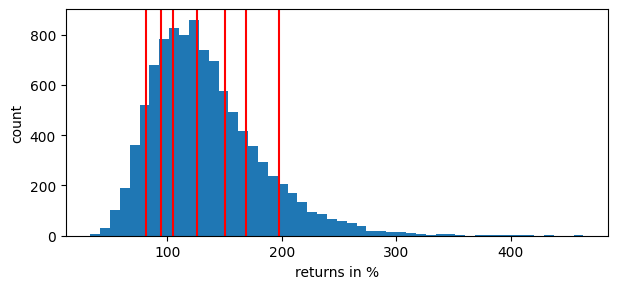

In [8]:
COUNT = 10000
data = 100 * many_market_monthly_diffs(years=YEARS, count=COUNT)[-1]
plt.hist(data, bins=50, color='C0')
percentiles_once = list(percentiles(data))
for p,v in percentiles_once:
    print(f"Percentile {p}: {v:.1f}")
    plt.axvline(x=v, color='red')
def print_below(sorted_data, limit=100.0):
    for i,v in enumerate(sorted_data):
        if v >= limit:
            lower = float(i) / COUNT
            print(f"{100*lower:.1f}% are below {limit}")
            break
print_below(data)
plt.xlabel('returns in %')
plt.ylabel('count')
plt.show()

## Borrowed Investment

What if we borrow the single investment and pay it off monthly?
Of course, we pay a little more in total because the monthly interest comes on top.

In [9]:
INTEREST_yearly = 2.0 / 100
INTEREST_monthly = (1 + INTEREST_yearly) ** (1.0/12) - 1
print(f"Monthly interest: {100 * INTEREST_monthly:.4f}")
payoff_monthly = 1 / 12 / YEARS
PAY_monthly = INTEREST_monthly + payoff_monthly
total = PAY_monthly * 12 * YEARS
print(f"Monthly payment: {PAY_monthly:.4f}, so in total {total:.2f} over {YEARS} years")
print(f"Monthly payment without interest: {payoff_monthly:.4f} which is a {100 * INTEREST_monthly / payoff_monthly:.2f}% difference")

Monthly interest: 0.1652
Monthly payment: 0.0183, so in total 1.10 over 5 years
Monthly payment without interest: 0.0167 which is a 9.91% difference


Percentile 10: -28.8%
Percentile 20: -15.5%
Percentile 30: -5.0%
Percentile 50: 16.0%
Percentile 70: 40.8%
Percentile 80: 58.6%
Percentile 90: 87.4%
34.6% are negative


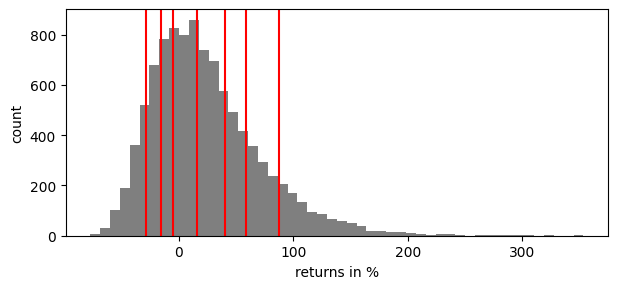

In [10]:
earnings = data - total * 100
for p,v in percentiles(earnings):
    print(f"Percentile {p}: {v:.1f}%")
    plt.axvline(x=v, color='red')
count_subzero = np.sum(earnings <= 0.0)
print(f"{100*count_subzero/COUNT:.1f}% are negative")
plt.hist(earnings, bins=50, color='C7')
plt.xlabel('returns in %')
plt.ylabel('count')
plt.show()

Compare the negative probability here with the probability for a single investment.
This is the risk increase for paying interest.

## Monthly Investment

Let us compare it with a monthly investment instead of paying off debt with the same monthly amount.

Percentile 10: 96.8
Percentile 20: 105.2
Percentile 30: 112.0
Percentile 50: 124.7
Percentile 70: 138.7
Percentile 80: 148.1
Percentile 90: 163.0
26.7% are below 109.90948781152134


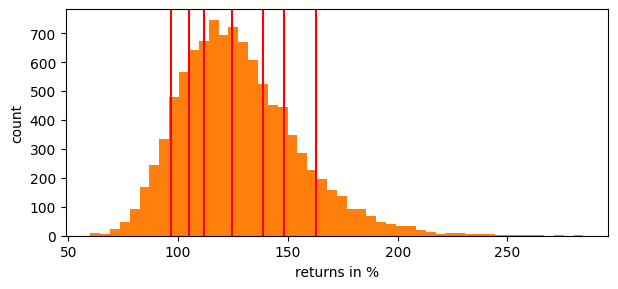

In [11]:
monthly = np.full((YEARS*12, COUNT), PAY_monthly)
dataM = many_market_monthly_diffs(years=YEARS, count=COUNT)
r = np.sum(100 * monthly * dataM, axis=0)
percentiles_monthly = list(percentiles(r))
for p,v in percentiles_monthly:
    print(f"Percentile {p}: {v:.1f}")
    plt.axvline(x=v, color='red')
print_below(r, total*100)
plt.hist(r, bins=50, color='C1')
plt.xlabel('returns in %')
plt.ylabel('count')
plt.show()

Compare the probability here with the one for a borrowed single investment.
That is the reduced risk for not paying interest but investing that part as well.
The probability is also slightly higher than the non-borrowed singled investment, since we invest more money.

Let's compare the percentiles of the monthly investment and the single investment.

In [12]:
for ((p1,v1), (p2,v2)) in zip(percentiles_monthly, percentiles_once):
    diff = (v2 - v1)
    diff_rate = diff / abs(v1 - (100*total))
    print (f"p{p1}: {v1:5.1f} vs {v2:5.1f}    = {diff:+5.1f} difference ({100*diff_rate:2.0f}%)")

p10:  96.8 vs  81.1    = -15.7 difference (-120%)
p20: 105.2 vs  94.4    = -10.8 difference (-230%)
p30: 112.0 vs 104.9    =  -7.1 difference (-335%)
p50: 124.7 vs 125.9    =  +1.2 difference ( 8%)
p70: 138.7 vs 150.7    = +12.1 difference (42%)
p80: 148.1 vs 168.5    = +20.4 difference (53%)
p90: 163.0 vs 197.3    = +34.3 difference (65%)


The median (p50) is better for the single investment.
The volatility is higher though as can be seen in p10 and p90.

More visually, we can overlay the distributions.
You can see the single investment having a wider distribution.
The advantage of the single investment can be seen by larger area on the right compare to the left.

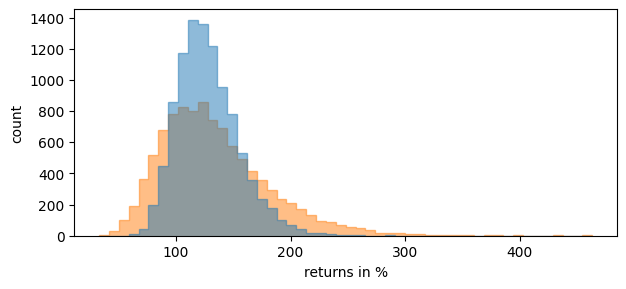

In [13]:
plt.hist([r,data], bins=50, alpha=0.5, histtype='step', fill=True)
plt.xlabel('returns in %')
plt.ylabel('count')
plt.show()